In [30]:
import numpy as np
from scipy.linalg import orth
import matplotlib.pyplot as plt
import random
%matplotlib inline 
from __future__ import division
from sklearn import preprocessing


In [48]:
def my_ppca(Ye, d):
    N, D = Ye.shape
    eps   = 1e-4;  
    hidden = np.isnan(Ye)
    missing = np.sum(hidden)
    
    mean = np.nanmean(Ye, axis=0)
    std = np.nanstd(Ye, axis=0)
    Ye = (Ye-mean)/std
   
    Ye[hidden] = 0
                
    C = np.random.randn(D, d)
    CtC = np.dot(C.T, C)
    X = np.dot(np.dot(Ye, C), np.linalg.inv(CtC))
    recon = np.dot(X, C.T)
    recon[hidden] = 0
    ss = np.sum((recon - Ye)**2)/(N*D - missing)
    
    count = 0
    old = np.inf
    
    while True:

            Sx = np.linalg.inv(np.eye(d) + CtC/ss)
            ss_old = ss
            if missing:
                proj = np.dot(X, C.T)
                Ye[hidden] = proj[hidden]
            X = np.dot(np.dot(Ye, C), (Sx/ss))  #e step

            SumXtX = np.dot(X.T, X)
            C = np.dot(np.dot(Ye.T, X), np.linalg.pinv(SumXtX + N*Sx))
            CtC = np.dot(C.T, C)
            ss = (np.sum((np.dot(X, C.T)-Ye)**2) + N*np.sum(CtC*Sx) + missing*ss_old)/(N*D)

            objective = N*D + N*(D*np.log(ss)+np.trace(Sx)-np.log(np.linalg.det(Sx))) \
                       +np.trace(SumXtX)-missing*np.log(ss_old);           
           
            rel_ch    = abs( 1 - objective / old );
            old       = objective;
            
            count += 1
    
            print "Objective: %.2f relative change: %.5f " % (objective, rel_ch)
        
            if ( rel_ch < eps) and (count > 5):
                break
    
    C = orth(C)
    vals, vecs = np.linalg.eig(np.cov(np.dot(Ye, C).T))
    order = np.flipud(np.argsort(vals))
    
    print order
    print vecs
    vals = vals[order]
    vecs = vecs[:, order]
    
    C = np.dot(C, vecs)
    X = np.dot(Ye, C)
    
    return X

Objective: 775.73 relative change: 1.00000 
Objective: 552.59 relative change: 0.28765 
Objective: 519.12 relative change: 0.06057 
Objective: 510.77 relative change: 0.01609 
Objective: 506.74 relative change: 0.00789 
Objective: 504.05 relative change: 0.00530 
Objective: 502.07 relative change: 0.00393 
Objective: 500.58 relative change: 0.00296 
Objective: 499.47 relative change: 0.00222 
Objective: 498.65 relative change: 0.00165 
Objective: 498.05 relative change: 0.00121 
Objective: 497.61 relative change: 0.00087 
Objective: 497.30 relative change: 0.00062 
Objective: 497.08 relative change: 0.00044 
Objective: 496.93 relative change: 0.00031 
Objective: 496.82 relative change: 0.00021 
Objective: 496.75 relative change: 0.00015 
Objective: 496.70 relative change: 0.00010 
Objective: 496.66 relative change: 0.00007 
[0 1]
[[ 0.99945269  0.03308043]
 [-0.03308043  0.99945269]]


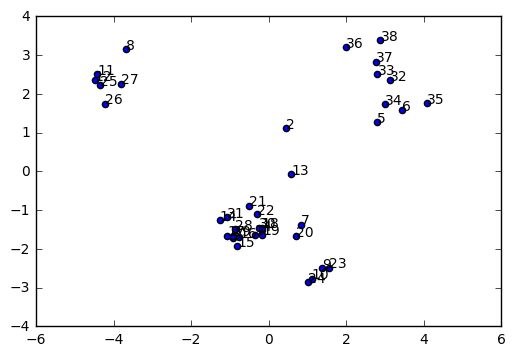

In [49]:
X1 = my_ppca(x_list, 2)
fig, ax = plt.subplots()
x = X1[:,0]
y = X1[:,1]
ax.scatter(x,y)
for i, txt in enumerate(range(1,39)):
    ax.annotate(txt, (x[i],y[i]))

In [39]:
f = open("virus2.dat")
line_list = f.read().split("\n")
line_list.pop()

x_list = np.array([ map(int, l.split(" ")) for l in line_list])

1.0
1.24342851717
2.98199263233
0.294988620514
0.060181588661
0.0228482977909
0.0138008239508
0.00971912048916
0.00704068151915
0.00508002383119
0.00362549233226
0.00255773259233
0.00178554681717
0.00123516406792
0.000847882684236
0.000578340214197
0.00039245126198
0.0002652129735
0.000178647543377
0.000120037757827
8.05058001108e-05


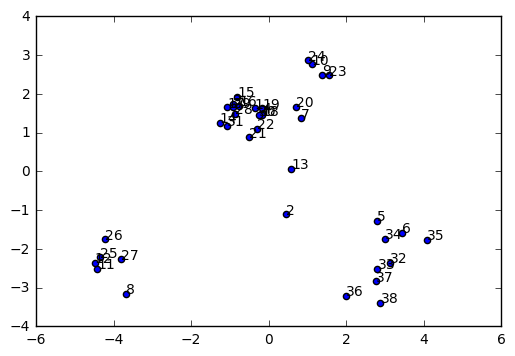

In [50]:
from ppca import PPCA
ppca = PPCA(x_list)
ppca.fit(d=2, verbose =True)
fig, ax = plt.subplots()
x = ppca.X[:,0]
y = ppca.X[:,1]
ax.scatter(x,y)
for i, txt in enumerate(range(1,39)):
    ax.annotate(txt, (x[i],y[i]))